# Discretizing the disk

The unit disk is a tensor-product domain---with a twist. Usually we think of $0\le r \le 1$ and $-\pi\le \theta < \pi$, but that formulation leads to an artificial singularity at the origin which then has to be remedied. It's better to start with 

$$
$-1 \le r \le 1$, \, $0 \le \theta < \pi$. 
$$

Choose discretization sizes and let

$$
h = \frac{2}{n_r}, \quad q = \frac{\pi}{n_{\theta}}. 
$$

In order to avoid trouble at $r=0$, we require that $n_r$ is odd. 

If $\bfU$ is a matrix of unknowns on a grid in $(r,\theta)$ space, then differentiation in $r$ is straightforward: $\bfD_r \bfU$. With respect to $\theta$, however, there is an implicit periodicity we have to respect: the row corresponding to $r=-1+kh$ should continue smoothly into the row at $r=1-kh$, and vice versa, to form data around one actual circle inside the unit disk. Let

$$
\bfJ = 
\begin{bmatrix}
  & & & 1 \\ & & 1 & \\ & \vdots & & \\ 1 & & & 
\end{bmatrix}. 
$$

Then 

$$
\begin{bmatrix}
  \bfU & \bfJ\bfU
\end{bmatrix}
$$

double-covers the disk but has rows with true periodicity. Thus, $\bfD_{\theta}$,  $\bfD_{\theta\theta}$, and so on can be defined in the usual way for periodic conditions on a discretization size $2n_{\theta}$, e.g.,

$$
\begin{bmatrix}
  \bfU & \bfJ\bfU
\end{bmatrix} \bfD_{\theta\theta}^T. 
$$

After differentiation, though, we want to discard the duplicated information and return to the standard discretization, which means discarding the last $n_\theta$ columns. Let 

$$
\bfD_{\theta\theta} = 
\begin{bmatrix}
  \bfQ_{11} & \bfQ_{12} \\ \bfQ_{21} & \bfQ_{22} 
\end{bmatrix}
$$

be a partitioning into $n\times n$ blocks. Then the full differentiation process can be expressed as 

$$
\begin{bmatrix}
  \bfU & \bfJ\bfU
\end{bmatrix}
\begin{bmatrix}
  \bfQ_{11}^T \\ \bfQ_{12}^T 
\end{bmatrix} 
= 
\bfU\bfQ_{11}^T + \bfJ \bfU \bfQ_{12}^T. 
$$

Following this process term by term for a linear differential operator leads to a Sylvester-style equation that we can transform using Kronecker products. 

::::{prf:example} Polar Laplacian
The Laplacian in polar coordinates is 

$$
\Delta u = \partial_{rr} u + \frac{1}{r} \partial_r u + \frac{1}{r^2} \partial_{\theta\theta} u. 
$$

Therefore, a discretization of this operator on the unit disk is

$$
\bfD_{rr} \bfU + \bfS \bfD_r \bfU + \bfS^2 \bfU\bfQ_{11}^T  +  \bfS^2 \bfJ \bfU\bfQ_{12}^T, 
$$

where $\bfS$ is a diagonal matrix of the values $1/r_i$ over all $n_r$ nodes. From here, things proceed as they did before. For a Poisson problem, this can be equated to a given grid function $\bfF$, at least before imposing boundary conditions (only at $r=\pm 1$). In order to use direct linear algebra, we can transform the equation to standard form using Kronecker products; for a Krylov subspace iteration, we can work directly with the form above. 
::::

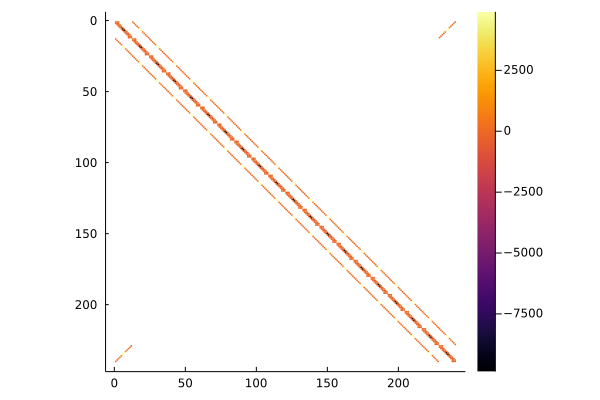

In [1]:
include("diffmats.jl")
function polarlap(nr,nθ)
    @assert isodd(nr)
    ⊗ = kron
    r,Dr,Drr = diffmats(nr,-1,1)
    S = spdiagm(1 ./r)
    q = π/nθ
    θ = q*(0:nθ-1)
    Dθθ = 1/q^2*spdiagm(
            0=>fill(-2.,2nθ),
            -1=>ones(2nθ),
            1=>ones(2nθ),
            2nθ-1=>[1.],
            1-2nθ=>[1.]
        )
    Q₁₁,Q₁₂ = Dθθ[1:nθ,1:nθ],Dθθ[nθ+1:2nθ,1:nθ]
    return r,θ,I(nθ)⊗(Drr + S*Dr) + Q₁₁⊗S.^2 + Q₁₂⊗reverse(S.^2,dims=2)
end

using Plots
r,θ,L = polarlap(11,20)
spy(L)

In [2]:
û(x,y) = x.^2 + 2y
f(x,y) = 2

nr,nθ = 39,58
r,θ,A = polarlap(nr,nθ)

X = [r*cos(θ) for r in r, θ in θ]
Y = [r*sin(θ) for r in r, θ in θ]

bdy = falses(nr+1,nθ)
bdy[1,:] .= true 
bdy = vec(bdy)

u = zeros(size(A,1))
u[bdy] = û.(X[bdy],Y[bdy])
inter = @. !bdy
Ã = A[inter,inter]
f̃ = f.(X[inter],Y[inter]) - A[inter,bdy]*u[bdy]
u[inter] = Ã\f̃;

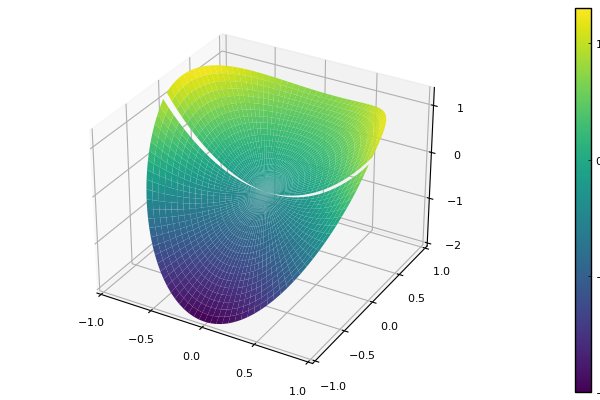

In [3]:
pyplot()
U = reshape(u,nr+1,nθ)
surface(X,Y,U,color=:viridis)